In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline

import pandas as pd

import json
import glob
import os

In [2]:
data = {}

for path in glob.glob(os.path.expanduser("../../data/results/weak_scaling_cmp/*.json")):
  for typename, items in json.load(open(path)).items():
    if typename in data:
      data[typename].update(items)
    else:
      data[typename] = items

frames = { typename: pd.DataFrame.from_dict(items, orient='index') for typename, items in data.items() }

In [3]:
dlslm_label = 'DSLM-Mod'
dlslm_me_label = 'DSLM-Map'
seq_postfix = ' w. Seq.'
no_contraction_postfix = ' w/o Contraction'
dlslm_ws_label = dlslm_label + seq_postfix
dlslm_nc_label = dlslm_label + no_contraction_postfix

algo_name_mapping = {
    'synchronous local moving with map equation': dlslm_me_label,
    'synchronous local moving with modularity': dlslm_label
}

frames['algorithm_run'].replace({ 'algorithm': algo_name_mapping }, inplace=True)

frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['switch_to_seq'].map({ False: '', True: seq_postfix, np.NaN: '' })
frames['algorithm_run']['algorithm'] += frames['algorithm_run'].merge(frames['program_run'], left_on='program_run_id', right_index=True, how='left')['contraction'].map({ False: no_contraction_postfix, True: '', np.NaN: '' })

In [4]:
frames['algorithm_run']['runtime'] = (frames['algorithm_run']['done_ts'] - frames['algorithm_run']['start_ts']) / 1000000.0
if 'distributed_algorithm_run_id' in frames['algorithm_run']:
    distributed_algo_runs = frames['algorithm_run'][pd.isnull(frames['algorithm_run'].distributed_algorithm_run_id)]
else:
    distributed_algo_runs = frames['algorithm_run']

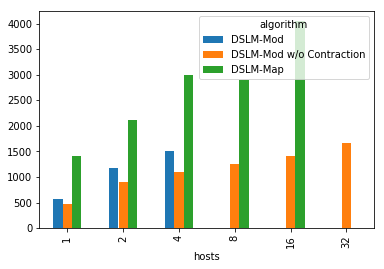

In [8]:
df = distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['hosts', 'algorithm'])['runtime'].mean().to_frame().unstack() \
    ["runtime"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]
    
df_errors = distributed_algo_runs \
    .merge(frames['program_run'], left_on='program_run_id', right_index=True) \
    .groupby(['hosts', 'algorithm'])['runtime'].std().to_frame().unstack() \
    ["runtime"][[dlslm_label, dlslm_nc_label, dlslm_me_label]]

df.plot(yerr=df_errors, kind='bar')